# Lessons Learned

In [1]:
import re as re

import geopandas as gpd
import numpy as np
import pandas as pd

pd.options.display.max_columns = 50
pd.options.display.max_rows = 250
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter
from itertools import chain, combinations

import altair as alt
import branca
import folium
import shared_utils
import utilities
from calitp import *
from shared_utils import altair_utils, styleguide
from siuba import *

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/consolidated_applications/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
FILE_NAME = "Con_App_Cleaned.xlsx"

In [3]:
pivoted_data = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="pivoted_data")

cleaned_unpivoted_data = pd.read_excel(
    f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="cleaned_unpivoted_data"
)
grouped_df = pd.read_excel(
    f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="combos_of_funding_programs"
)

In [4]:
df_geometry = gpd.read_parquet(f"{GCS_FILE_PATH}con_app_gdf.parquet")

In [5]:
type(df_geometry)

geopandas.geodataframe.GeoDataFrame

## Basics

In [6]:
f'{cleaned_unpivoted_data.project_upin.nunique()} total applications'

'346 total applications'

In [ ]:
f'{cleaned_unpivoted_data.organization_name.nunique()} different organizations.'

In [7]:
print('How many applications were submitted through the consolidated application?')
cleaned_unpivoted_data.consolidated_application.value_counts()

How many applications were submitted through the consolidated application?


Yes    343
No       3
Name: consolidated_application, dtype: int64

In [8]:
print('How many applications were submitted vs. not submitted?')
cleaned_unpivoted_data.application_status.value_counts()

How many applications were submitted vs. not submitted?


Submitted        338
Not Submitted      8
Name: application_status, dtype: int64

## Total Funds Requested
* Only includes 'state total' and 'federal total.'

In [9]:
totals = cleaned_unpivoted_data[['total_state_fed_only']]
totals = totals.append(
        totals.sum(numeric_only=True), ignore_index=True).tail(1)
totals["total_state_fed_only"] = (
    "$"
    + (totals["total_state_fed_only"].astype(float) / 1000000)
    .round()
    .astype(str)
    + "M"
)
totals

/tmp/ipykernel_1573/477148160.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,total_state_fed_only
346,$624.0M


## How much funding was requested - State v. Federal Grants?
<img src="bar_funding source_by_total.png">

In [10]:
funding_all = cleaned_unpivoted_data[['state_total','federal_total']]

In [11]:
funding_all = funding_all.append(
        funding_all.sum(numeric_only=True), ignore_index=True).tail(1)

/tmp/ipykernel_1573/1462360091.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [12]:
funding_all = funding_all.T.reset_index()

In [13]:
funding_all = funding_all.rename(columns = {'index':'funding source', 346: 'total'})

In [14]:
#utilities.basic_bar_chart( funding_all, "funding source", "total", "funding source", "Total Funds Requested")

## What are the most popular funds, looking at amount requested?

<img src= "bar_amount requested_by_grant.png">

In [15]:
federal_state_only = cleaned_unpivoted_data[
    [
        "_5311_funds",
        "_5311_f__funds",
        "_5311_cmaq_funds",
        "_5339_funds",
        "other_fed_funds_total",
        "lctop__state__funds",
        "sb1__state_of_good_repair__state__funds",
        "transit_development_act__state__funds",
        "other_state_funds",
    ]
]

In [16]:
federal_state_only = (
    federal_state_only.append(
        federal_state_only.sum(numeric_only=True), ignore_index=True
    )
    .tail(1)
    .T.reset_index()
    .rename(columns={"index": "grant", 346: "amount requested"})
)

/tmp/ipykernel_1573/943889312.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [17]:
federal_state_only["grant"] = federal_state_only["grant"] .replace(
    {
        "_5311_funds": "5311 (Fed)",
        "lctop__state__funds": "LCTOP (State)",
        "transit_development_act__state__funds": "Transit Development Act (State)",
        "other_state_funds": "Other State Funds",
        "_5339_funds": "5339 (Fed)",
        "_5311_f__funds": "5311(f) (Fed)",
        "sb1__state_of_good_repair__state__funds": "SB1. State of Good Repair (State)",
        "other_fed_funds_total": "Other Federal Funds",
        "_5311_cmaq_funds": "5311 CMAQ (Fed)",
        "local_total": "Local Funds",
        "federal_total": "Federal Total",
        "state_total": "State Total",
    }
)

In [18]:
federal_state_only.grant.unique()

array(['5311 (Fed)', '5311(f) (Fed)', '5311 CMAQ (Fed)', '5339 (Fed)',
       'Other Federal Funds', 'LCTOP (State)',
       'SB1. State of Good Repair (State)',
       'Transit Development Act (State)', 'Other State Funds'],
      dtype=object)

In [19]:
federal_state_only = federal_state_only.sort_values("amount requested", ascending = False)
federal_state_only["amount requested"] = federal_state_only["amount requested"].astype('int64').round(0)
federal_state_only["amount requested (millions)"] = (
    "$"
    + (federal_state_only["amount requested"].astype(float) / 1000000)
    .round(0)
    .astype(str)
    + "M"
)

In [20]:
LEGEND = ['LCTOP (State)', 'Other State Funds',
       'Transit Development Act (State)', '5311 (Fed)',
       'Other Federal Funds', '5339 (Fed)', '5311(f) (Fed)',
       '5311 CMAQ (Fed)', 'SB1. State of Good Repair (State)']

In [51]:
#federal_state_only = utilities.fancy_bar_chart(federal_state_only, LEGEND, "grant", "amount requested", "amount requested (millions)", "Total Funds Requested")

## Are projects fully funded? 
<b> Methodology </b>
* Totaled out "local total", "federal total", "other federal funds", and "state funds".
* Compared the total above with "total expenses" column. 
<img src='bar_fully_funded_by_number of projects.png'>

In [22]:
fully_funded = utilities.value_function(cleaned_unpivoted_data, "fully_funded")
fully_funded = fully_funded.rename(columns = {'values':'number of projects'})

In [23]:
#utilities.basic_bar_chart(fully_funded, "fully_funded", "number of projects", "fully_funded", "Projects by Fully Funded Status")

## What do organizations want to use their funding for?
* Most applications are for projects related to Operating Assistance. 
<img src= "bar_values_by_project type.png">

In [24]:
cleaned_unpivoted_data = cleaned_unpivoted_data.rename(columns = {'short_description':'project type'})
project_types = utilities.value_function(cleaned_unpivoted_data, "project type")

In [52]:
#utilities.basic_bar_chart(project_types, "values", "project type", "project type", "Project Types")

## What are the most popular combinations of programs an organization applies for?
* There are only 335 rows in this data set. There are 346 rows in the original dataframe. 
    * This is due to the fact that I had to pivot the data different and filtered out any rows with $0 below across all monetary fields and rows with values populated <b>only</b> in the state total or federal total columns.


* Looking at the top ten most popular combination of programs
    * Majority of applications only applied for LCTOP, followed by 5311.
    

In [26]:
combos = utilities.value_function(grouped_df, "all_programs")

In [27]:
Total = combos["values"].sum()
combos["percentage_of_total_applications"] = combos["values"] / Total
combos["percentage_of_total_applications"] = (
    combos["percentage_of_total_applications"].astype(float).map("{:.0%}".format)
)

In [28]:
combos.head(10).style.bar(subset = ['values'], color = '#8CBCCB')

,all_programs,values,percentage_of_total_applications
0,LCTOP (State),99,30%
1,5311 (Fed),72,21%
2,"5311 (Fed),Transit Development Act (State)",39,12%
3,5339 (Fed),29,9%
4,5311(f) (Fed),15,4%
5,"5311 (Fed),Other State Funds",14,4%
6,"5339 (Fed),Other State Funds",11,3%
7,"5311(f) (Fed),Transit Development Act (State)",9,3%
8,5311 CMAQ (Fed),6,2%
9,"5311 (Fed),SB1. State of Good Repair (State),Transit Development Act (State)",5,1%


## Analyzing applications that include LCTOP and at least one other grant: 
* 23 total applications.
* 11 different combinations of applications including LCTOP and 1+ program. 
* LCTOP and Other State Funds is the most popular combination, followed by 5311 and LCTOP.

In [29]:
lctop_combos = grouped_df[(grouped_df.all_programs.str.contains("lctop", case=False))]
lctop_combos = lctop_combos[(lctop_combos["count_of_funding_programs_applied"] > 1)]

In [30]:
lctop_combos = (
    lctop_combos.groupby(["all_programs"])
    .agg({"project_upin": "nunique"})
    .sort_values("project_upin", ascending=False)
    .reset_index()
)

In [31]:
lctop_combos = lctop_combos.rename(
    columns={
        "all_programs": "program combinations",
        "project_upin": "count of applications in this combination",
    }
)

In [32]:

lctop_combos.style.bar(subset = ['count of applications in this combination'], color = '#B9D6DF') 

,program combinations,count of applications in this combination
0,"LCTOP (State),Other State Funds",5
1,"5311 (Fed),LCTOP (State)",3
2,"5311 (Fed),LCTOP (State),SB1. State of Good Repair (State),Other State Funds",2
3,"5311 (Fed),LCTOP (State),SB1. State of Good Repair (State),Transit Development Act (State),Other State Funds",2
4,"5311 (Fed),LCTOP (State),Transit Development Act (State)",2
5,"5311 (Fed),LCTOP (State),Transit Development Act (State),Other State Funds,Other Federal Funds",2
6,"LCTOP (State),SB1. State of Good Repair (State)",2
7,"5311 (Fed),LCTOP (State),Other Federal Funds",1
8,"5311 CMAQ (Fed),LCTOP (State),Other State Funds",1
9,"LCTOP (State),Other Federal Funds",1


## How many applications did organizations submitted?
<b> Methodology </b> 
* <b> Step 1 </b>: Grouped by organization name and count the number of project upin numbers. Each upin number is unique to each application. ,
    * Example: Amador Transit applied 6 separate times.
* <b> Step 2 </b>: Group again to see how many organizations applied for 1,2, etc. applications
    * 38 organizations submited 1 application.
    * 7 organizations submitted 4 applications.
<img src= "bar_count of organizations_by_apps submitted.png">

In [33]:
apps_submitted = (
    cleaned_unpivoted_data.groupby(["organization_name"])
    .agg({"project_upin": "count"})
    .reset_index()
    .groupby(["project_upin"])
    .agg({"organization_name": "count"})
    .reset_index()
    .rename(
        columns={
            "project_upin": "apps submitted",
            "organization_name": "count of organizations",
        }
    )
)

In [34]:
apps_submitted['apps submitted'] = apps_submitted['apps submitted'].replace(
    {
      1: 'one',
        2:'two',
        3:'three',
        4:'four',
        5:'five',
        6:'six',
        7:'seven',
        8:'eight',
        9:'nine',
        13:'thirteen'
    }
)

In [53]:
#utilities.basic_bar_chart(apps_submitted, "count of organizations", "apps submitted", "apps submitted", "# of Organizations and the # of Applications They Submitted")

## Analyzing Districts
* Most applications were submitted by agencies in District 6. 

In [81]:
TOOLTIP_KWARGS = {
    "min_width": 50,
    "max_width": 100,
    "font_size": "12px",
}

In [82]:
popup_dict = {
    "DISTRICT": "Caltrans District",
    "project_upin": "Total applications from organizations in this district",
    "total_state_fed_only": "Total funding requested",
}

In [83]:
tooltip_dict = {
    "DISTRICT": "Caltrans District",
    "project_upin": "Total applications from organizations in this district",
    "total_state_fed_only": "Total funding requested",
}

In [97]:
color_scale = branca.colormap.StepColormap(
    colors=["#F6BF16", "#E16B26", "#00896B"],
    index=[0, 25, 60],
    vmin=0,
    vmax=100,
)
color_scale

In [104]:
shared_utils.map_utils.make_folium_choropleth_map(df_geometry,
    plot_col = 'total_state_fed_only',
    popup_dict = popup_dict,
    tooltip_dict = tooltip_dict,
    colorscale = color_scale,
    fig_width = int(700),
    fig_height = int(700),
    zoom=REGION_CENTROIDS["CA"][1],
    centroid=REGION_CENTROIDS["CA"][0],
    title="Districts by Funding",
    legend_name="DISTRICT")

KeyError: 1

In [85]:
REGION_CENTROIDS = shared_utils.map_utils.REGION_CENTROIDS

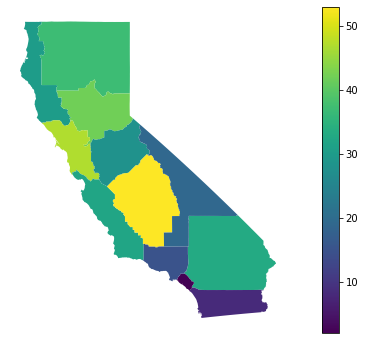

In [99]:
map1 = df_geometry.plot(figsize=(12,6), column = 'project_upin', legend = True ).axis("off")

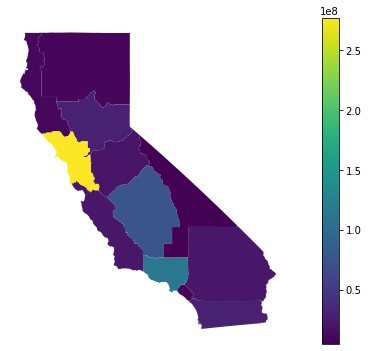

In [100]:
map2 = df_geometry.plot(figsize=(12,6), column = 'total_state_fed_only', legend = True ).axis("off")

## Which organizations applied? How much did they ask for?

In [88]:
organizations = (cleaned_unpivoted_data.groupby(['full_district_name','organization_name'])
                 .agg({'state_total':'sum','federal_total':'sum'})
                )


In [89]:
organizations['total'] = organizations['state_total'] + organizations['federal_total']
organizations = organizations[['total']]

In [90]:
organizations['total'] = organizations['total'].astype('int64')

In [91]:
def color(value):
    if value <  496292.00:
        color = "#E16B26" #orange
    elif 496292.00 < value < 3393431:
        color =  "#8CBCCB" #light blue
    else:
        color =  "#136C97" #dark blue
    return f'background-color: {color}'

### Color Guide
* The lower the funding requested, the darker the orange. The higher, the darker the blue. 

In [92]:
organizations.sort_values('full_district_name').style.applymap(color, subset=['total'])

## What mix of funds did organizations apply for?
<b>Interpretation Examples</b>
* Amador Transit submitted 4 separate applications only for 5339. Submitted 2 separate applications asking for both LCTOP and 5311 funds.
* City of Escalon had 1 application, only for 5311 fund. 
    * They submitted 2 applications applying to a total of 5 programs: 5311 (Fed),LCTOP (State),SB1. State of Good Repair (State),Transit Development Act (State),Other State Funds
* Eastern Sierra Transit Authority submitted 13 different applications. 
    * 4 applications were for 5311 only.
    * 1 application for 5311f and Transit Development Act
    * 1 for 5311f, Transit Devleopment Act, and Other State Funds
    * 4 for 5339 only
    * 2 for LCTOP only
    * 1 for LCTOP and SB1 State of Good Repair.

In [93]:
organizations_combo = grouped_df.groupby(["organization_name", "all_programs"]).agg(
    {"count_of_funding_programs_applied": "max", "all_programs": "count"}
)

In [94]:
organizations_combo = organizations_combo.rename(
    columns={
        "count_of_funding_programs_applied": "# of programs in a particular application",
        "all_programs": "# of times the org submitted an application in this particular combination",
    }
)

In [95]:
organizations_combo.head(201)

# of programs in a particular application  \
organization_name                                               all_programs                                                                                                                                              
Alameda-Contra Costa Transit District                           LCTOP (State)                                                                                                                                         1   
Amador Transit                                                  5311 (Fed),LCTOP (State)                                                                                                                              2   
                                                                5339 (Fed)                                                                                                                                            1   
Butte County Association of Governments/ Butte Regional Transit 5311 (Fed),Transit Development Act (State)                                                                                                            2   
                                                                5311(f) (Fed),Transit Development Act (State)                                                                                                         2   
Calaveras Transit Agency                                        5311 (Fed),Transit Development Act (State)                                                                                                            2   
                                                                LCTOP (State)                                                                                                                                         1   
City of Arcata                                                  LCTOP (State)                                                                                                                                         1   
City of Arvin                                                   5311 (Fed),Transit Development Act (State)                                                                                                            2   
                                                                5339 (Fed)                                                                                                                                            1   
City of Auburn                                                  5311 (Fed),SB1. State of Good Repair (State),Transit Development Act (State)                                                                          3   
City of Banning                                                 LCTOP (State)                                                                                                                                         1   
City of Beaumont                                                LCTOP (State)                                                                                                                                         1   
City of California City                                         5311 (Fed)                                                                                                                                            1   
City of Chowchilla                                              5311 (Fed),Transit Development Act (State)                                                                                                            2   
City of Clovis                                                  LCTOP (State)                                                                                                                                         1   
City of Corcoran - Corcoran Area Transit                        5311 (Fed)                                                                                                                                            1   
             